In [1]:
import numpy as np
import skimage
import math

## Get the dataset

In [2]:
!ls

Dataset  pdf  tp1.ipynb


In [3]:
import glob

path_images = glob.glob("./Dataset/*.jpg")
list_images = []
for img in path_images:
    im = skimage.io.imread(img)
    list_images.append(im)
    
len(list_images)

9

In [4]:
class Cluster:
    
    def __init__(self, l, a, b, x, y):
        self.l = l
        self.a = a
        self.b = b
        self.x = x
        self.y = y
        
        self.t = np.array([l, a, b, x, y]).T
        self.pixel = []
        
    def update(self, l, a, b, x, y):
        self.l = l
        self.a = a
        self.b = b
        self.x = x
        self.y = y
        
        self.t = np.array([l, a, b, x, y]).T
        return self
    

In [20]:
def init_cluster(image, S):
    cluster = []
    x = S // 2
    y = S // 2
    while x < image.shape[0]:
        while y < image.shape[1]:
            C_k = Cluster(image[x, y, 0], image[x, y, 1], image[x, y, 2], int(x), int(y))
            cluster.append(C_k)
            y += S // 2
        x += S // 2
        y = S // 2
    return cluster

def gradient(image, x, y):
    x = int(x)
    y = int(y)
    if x + 1 >= image.shape[0]:
        x = image.shape[0] - 2
    if y + 1 >= image.shape[1]:
        y = image.shape[1] - 2

    gradient = image[x + 1][y + 1][0] - image[x][y][0] + \
               image[x + 1][y + 1][1] - image[x][y][1] + \
               image[x + 1][y + 1][2] - image[x][y][2]
    return gradient

def move_cluster(image, clusters):
    counter = 0
    for cluster in clusters:
        grad = gradient(image, cluster.x, cluster.y)
        for derx in range(-1, 2):
            for dery in range(-1, 2):
                x = (cluster.x) + derx
                y = (cluster.y) + dery
                new_grad = gradient(image, derx, dery)
                if new_grad < grad:
                    cluster.update(image[x, y, 0], image[x, y, 1], image[x, y, 2], x, y)
                    grad = new_grad
        counter += 1


def assign(image, clusters, S, dis, res, m=40):
    counter = 0
    for C_k in clusters:
        for x in range((C_k.x) - 2 * S, (C_k.x) + 2 * S):
            if x < 0 or x >= image.shape[0]:
                continue
            for y in range((C_k.y) - 2 * S, (C_k.y) + 2 * S):
                if y < 0 or y >= image.shape[1]:
                    continue
                
                d_lab = math.sqrt((image[x,y,0] - C_k.l)**2 + (image[x,y,1] - C_k.a)**2 + (image[x,y,2] - C_k.b)**2)
                d_xy = math.sqrt((x - C_k.x)**2 + (y - C_k.y)**2)
                D = math.sqrt(math.pow(d_lab / m, 2) + math.pow(d_xy / S, 2))
                
                if D < dis[x, y]:
                    if (x, y) not in res:
                        res[(x, y)] = C_k
                        C_k.pixel.append((x, y))
                    else:
                        res[(x, y)].pixel.remove((x, y))
                        res[(x, y)] = C_k
                        C_k.pixel.append((x, y))
                    dis[x , y] = D
                
        counter += 1
    return (res, dis)


def update_cluster(image, clusters):
    for C_k in clusters:
        sum_x = 0
        sum_y = 0
        number = 0
        for pix in C_k.pixel:
            sum_x += pix[0]
            sum_y += pix[1]
            number += 1
            x = int(sum_x / number)
            y = int(sum_y / number)
            
            C_k.update(image[x, y, 0], image[x, y, 1], image[x, y, 2], x, y)
            
def save_current_image(image, cluster):
    image_arr = np.copy(image)
    for C_k in cluster:
        for p in C_k.pixel:
            image_arr[p[0], p[1], 0] = C_k.l
            image_arr[p[0], p[1], 1] = C_k.a
            image_arr[p[0], p[1], 2] = C_k.b
    return image_arr

def super_pixel(image, K):
    print(image.shape)
    N = image.shape[0] * image.shape[1]
    S = int(math.sqrt(N / K))
    print(S)
    
    lab_image = skimage.color.rgb2lab(image)
    cluster = init_cluster(lab_image, S)
    move_cluster(lab_image, cluster)
    res = {}
    dis = np.full((image.shape[0], image.shape[1]), np.inf)
    (res, dis) = assign(lab_image, cluster, S, dis, res)
    update_cluster(lab_image, cluster)
        
    return save_current_image(lab_image, cluster)

In [31]:
%%timeit

final_image = super_pixel(list_images[6], 100)

%time

(321, 481, 3)
39
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
(321, 481, 3)
39


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))

plt.imshow(skimage.color.lab2rgb(final_image))
plt.show()

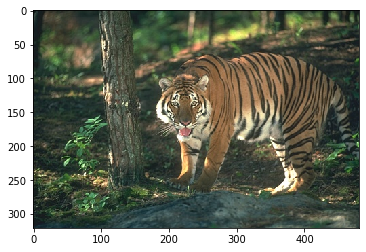

In [17]:
plt.imshow(list_images[6])